# EV3 Character Recognition Experiment - Predict

1. Prompt the user to place a character on the lego rotating platform
2. Run character scan experiment on EV3
3. Upload logged data file back to PC
4. Process raw data - clean and categorise into rotation buckets
5. Plot graphs of rotation vs reflectivity - including mean and median plots
6. Load machine learning model
7. Predict character
8. Show predictions for each data row and/or most frequent prediction

## Run experiment on EV3 and return datalog file

In [147]:
import subprocess
from subprocess import call
from IPython.display import Markdown as md

In [148]:
def get_prediction_data(logfile, rotations=10, interval=40):
    '''Scan character on reflectivity platform'''

    print(f'Place character on the platform')

    # Execute the 'main.py' script on the ev3. Existing logs (prefixed <filename> are deleted first)
    call(["ssh", "ev3", f"cd ./number_predict; rm {logfile}*; \
          brickrun -r -- pybricks-micropython main.py --interval {interval} --rotations {rotations} --filename {logfile}"])

    # Copy the results log generated by the script back to the local PC
    subprocess.run(["scp", f"ev3:~/number_predict/{logfile}*", "./raw_data"])

    print(f'  - Character has been scanned')

In [149]:
rotations = 3
filename = 'predict'

get_prediction_data(logfile=filename, rotations=rotations)

Place character on the platform
  - Character has been scanned


## Process raw data results

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [151]:
# Get location and name of latest prediction file from the list of '<filename>' files in current directory
prediction_file = !ls ./raw_data | grep -e $filename
prediction_file = prediction_file[-1]
!pwd
print(prediction_file)

/Users/garry/documents/github/datapiquing/lego/character recognition/ev3/number_predict
predict_2020_04_12_09_46_54_484249.csv


In [152]:
# Read the prediction data into a DataFrame
df_predict = pd.read_csv(f'./raw_data/{prediction_file}', index_col=False)
df_predict.head(10)

,angle,reflectivity
0,5,6
1,14,7
2,24,5
3,34,6
4,42,5
5,52,5
6,61,5
7,72,4
8,81,4
9,91,4


In [153]:
# Get the DataFrame dimensions
df_predict.shape

(120, 2)

In [154]:
# Get information about the datalog DataFrame
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   angle          120 non-null    int64
 1    reflectivity  120 non-null    int64
dtypes: int64(2)
memory usage: 2.0 KB


In [155]:
df_predict.columns

Index(['angle', ' reflectivity'], dtype='object')

In [156]:
# Remove the space that prefixes the 'reflectivity' column name
df_predict.columns = ['angle', 'reflectivity']

In [157]:
def create_rotation_dict():
    '''Initialise a dictionary with keys of 0 to 360 at 10 degree intervals, each with value zero'''
    degree_bins = list(range(0,361,10))
    rotation_dict = {}
    for bin in degree_bins:
        rotation_dict[bin] = 0
    return rotation_dict

In [158]:
# A function to place rotation values into buckets of 10 degrees (+ or - 5 degrees either side)
# These will be the feature columns of each sample rotation

def rotation_buckets(degrees):
    '''Calculate which 360 degree bucket (width=10) the rotation belongs'''
    if degrees > 360 and degrees%360 < 5:
        degrees = (degrees - 5)%360
    else:
        degrees = degrees%360
    modulus = degrees%10
    if modulus < 5:
        bucket = degrees - modulus
    else:
        bucket = (degrees - modulus) + 10
    return bucket

In [159]:
def create_clean_dataframe(raw_prediction_dataframe):
    '''Preprocess raw prediction data'''
    
    df_raw_data = raw_prediction_dataframe
    
    # The experiment was 1 run of X x 360 degree rotations
    # Put actual rotation angle into buckets of 10 degrees between 0 and 360 degrees
    # Concatenate each run of X rotations vertically as tuples of (bucket_degrees, reflectivity_percentage)

    results_list = []
    rotation_column = 'angle'
    reflectivity_column = 'reflectivity'
    for index, row in df_raw_data.iterrows():
        prev_bucket_degrees = -1
        actual_degrees = row[rotation_column]
        bucket_degrees = rotation_buckets(actual_degrees)
        relectivity_percentage = row[reflectivity_column]
        #print(actual_degrees, bucket_degrees, relectivity_percentage)
        results_list.append((bucket_degrees, relectivity_percentage))
        
    # Convert the list of result tuples (rotation angle, refelctivity) to a dictionary of dictionaries where
    # the key is the run number and the value is a dictionary of rotation angles (from 0 to 360 degrees at 
    # 10 degree intervals) and their respective reflectivity value

    run = 0
    results = {}
    dict = create_rotation_dict()
    at_360 = False
    for tuple in results_list:
        if tuple[0] < 360 or at_360 == False:
            dict[tuple[0]] = tuple[1]    
            if tuple[0] >= 360:
                results[run] = dict
                run += 1
                dict = create_rotation_dict()

        at_360 = (tuple[0] >= 360) 
        
    # Create a DataFrame from the angle vs reflectivity results

    df_results = pd.DataFrame.from_dict(results)
    
    # Transpose the DataFrame so each rotation sample is a row and each 10 degree angle of rotation 
    # between 0 and 360 degrees is a feature column

    df_results = df_results.transpose()
    
    # Impute and zero values
    # For angles 0 - 10 degrees use the value of 360 degrees

    df_results[0] = np.where(df_results[0] == 0, df_results[360], df_results[0])
    
    # Where a cell value is zero convert to NaN

    df_results[df_results.eq(0)] = np.nan
    
    # Replace NaN values with the column mean

    df_results.fillna(df_results.mean().astype(int), inplace=True)
    df_results = df_results.astype(int)
    
    # Export the number DataFrame to a .csv file
    df_results.to_csv('./clean_data/prediction_dataset.csv', index=False)
    
    return df_results

In [160]:

df_clean_prediction_data = create_clean_dataframe(df_predict)

df_clean_prediction_data

,0,10,20,30,40,50,60,70,80,90,...,270,280,290,300,310,320,330,340,350,360
0,7,6,6,6,6,5,5,4,5,4,...,4,5,5,6,6,6,6,7,6,7
1,6,6,6,5,6,5,4,5,5,5,...,5,6,5,6,6,6,7,6,7,6


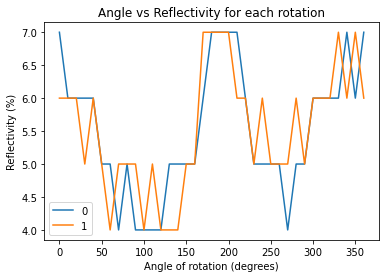

In [161]:
# Plot all X rotations on the same graph of rotation vs reflectivity

df_clean_prediction_data.transpose().plot(legend=False)
plt.legend()
plt.title('Angle vs Reflectivity for each rotation')
plt.xlabel('Angle of rotation (degrees)')
plt.ylabel('Reflectivity (%)')
plt.show()

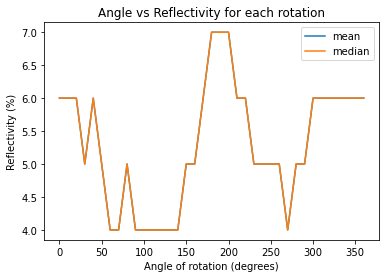

In [162]:
df_clean_prediction_data.mean().astype(int).plot(label = 'mean')
df_clean_prediction_data.median().astype(int).plot(label = 'median')
plt.legend()
plt.title('Angle vs Reflectivity for each rotation')
plt.xlabel('Angle of rotation (degrees)')
plt.ylabel('Reflectivity (%)')
plt.show()

## Predict Character

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [164]:
# Load machine learning (kNN) model

knn_model = pickle.load(open('./ml_model/number_reflectivity_knn_model', 'rb'))

In [165]:
# Assign results to the feature variable

X_pred = df_clean_prediction_data
X_pred.head()

,0,10,20,30,40,50,60,70,80,90,...,270,280,290,300,310,320,330,340,350,360
0,7,6,6,6,6,5,5,4,5,4,...,4,5,5,6,6,6,6,7,6,7
1,6,6,6,5,6,5,4,5,5,5,...,5,6,5,6,6,6,7,6,7,6


In [166]:
# Predict the character (target value) represented by each row of feature reflectivity values
y_pred = knn_model.predict(X_pred)

In [167]:
# Instead of setting the cell to Markdown, create Markdown from withnin a code cell!
# We can just use python variable replacement syntax to make the text dynamic
n = 10
md(f"# Test set predictions: {y_pred}")

# Test set predictions: [4 4]

In [186]:
result = y_pred[0]
call(["ssh", "ev3", f"cd ./number_predict; \
      brickrun -r -- pybricks-micropython main.py --predict {result}"])

1

## Need to fix the error with reduced rows due to missing 369

In [169]:
# Could take the most frequently occurring prediction as the result
# Alternatively, analyse one row of just the mean or median values

In [170]:
# 4 is predicted incorrectly

In [171]:
# Display the training graph against the result graph
# Use different machine learning models
# Use different hyperparameters - construct graphs of values vs accuracy
# Some error handling or printed output from the subprocess commands
# Train model with much more data
# Train full alphabet - upper and lowecase
# Train using horizontal/vertical scan instead of rotational scan ... feed letters in via horizontal moving conveyor 
# or down/up a vertical guide
# Predict as each character passes on conveyor and display on brick